# 🦟 Tech Challenge - Sistema de Diagnóstico de Dengue com ML

## Objetivo
Desenvolver um modelo de Machine Learning capaz de classificar casos suspeitos de dengue em **Confirmado** ou **Descartado**, utilizando dados clínicos e epidemiológicos do SINAN (2022).

## 1. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, roc_auc_score, precision_score

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Interpretação
import shap

# Configurações
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')
%matplotlib inline

## 2. Carregamento dos Dados

In [2]:
# Carregar Dataset com robustez
filename = 'DENGBR22.csv'
if os.path.exists(filename):
    df = pd.read_csv(filename, low_memory=False)
    print(f"✓ Dataset carregado! Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
else:
    raise FileNotFoundError(f"Arquivo {filename} não encontrado. Verifique se ele está na mesma pasta do notebook.")

✓ Dataset carregado! Dimensões: 1393877 linhas x 121 colunas


In [3]:
print("Amostra dos dados:")
df.head()

Amostra dos dados:


,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,SEM_PRI,ANO_NASC,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_PAIS,DT_INVEST,ID_OCUPA_N,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,DT_CHIK_S1,DT_CHIK_S2,DT_PRNT,RES_CHIKS1,RES_CHIKS2,RESUL_PRNT,DT_SORO,RESUL_SORO,DT_NS1,RESUL_NS1,DT_VIRAL,RESUL_VI_N,DT_PCR,RESUL_PCR_,SOROTIPO,HISTOPA_N,IMUNOH_N,HOSPITALIZ,DT_INTERNA,UF,MUNICIPIO,TPAUTOCTO,COUFINF,COPAISINF,COMUNINF,CLASSI_FIN,CRITERIO,DOENCA_TRA,CLINC_CHIK,EVOLUCAO,DT_OBITO,DT_ENCERRA,ALRM_HIPOT,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,DT_ALRM,GRAV_PULSO,GRAV_CONV,GRAV_ENCH,GRAV_INSUF,GRAV_TAQUI,GRAV_EXTRE,GRAV_HIPOT,GRAV_HEMAT,GRAV_MELEN,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,DT_GRAV,MANI_HEMOR,EPISTAXE,GENGIVO,METRO,PETEQUIAS,HEMATURA,SANGRAM,LACO_N,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,TP_SISTEMA,NDUPLIC_N,DT_DIGITA,CS_FLXRET,FLXRECEBI,MIGRADO_W
0,2,A90,2022-01-12,202202,2022,12,120020,1941.0,6801099.0,2022-01-06,202201,1975.0,4046,M,6.0,4.0,9.0,12,120033.0,1941.0,1.0,2022-01-12,NaN,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,NaN,NaN,1.0,NaN,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2022-01-17,NaN,NaN,NaN
1,2,A90,2022-08-11,202232,2022,12,120020,1941.0,5336171.0,2022-08-03,202231,1952.0,4069,M,6.0,4.0,9.0,12,120033.0,1941.0,1.0,2022-08-11,NaN,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,2022-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2022-08-12,NaN,NaN,NaN
2,2,A90,2022-03-25,202212,2022,12,120020,1941.0,2002116.0,2022-03-21,202212,1966.0,4056,M,6.0,4.0,6.0,12,120020.0,1941.0,1.0,2022-03-25,NaN,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-25,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,NaN,NaN,1.0,NaN,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2022-03-31,NaN,NaN,NaN
3,2,A90,2022-03-07,202210,2022,12,120020,1941.0,6801099.0,2022-03-04,202209,1978.0,4043,M,6.0,4.0,3.0,12,120020.0,1941.0,1.0,2022-03-07,NaN,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-07,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,NaN,NaN,1.0,NaN,2022-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2022-03-23,NaN,NaN,NaN
4,2,A90,2022-01-18,202203,2022,12,120020,1941.0,6801099.0,2022-01-18,202203,1977.0,4044,F,5.0,4.0,9.0,12,120020.0,1941.0,1.0,2022-01-18,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,NaN,NaN,1.0,NaN,2022-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2022-01-26,NaN,NaN,NaN


In [4]:
# Diagnóstico de CLASSI_FIN
print("Tipos de dados em CLASSI_FIN:")
print(df['CLASSI_FIN'].dtype)
print("\nValores únicos em CLASSI_FIN:")
print(df['CLASSI_FIN'].value_counts(dropna=False))

Tipos de dados em CLASSI_FIN:
float64

Valores únicos em CLASSI_FIN:
CLASSI_FIN
10.0    1223156
8.0      149045
11.0      18654
12.0       1540
NaN        1482
Name: count, dtype: int64


## 3. Pré-processamento

In [5]:
# 1. Filtrar Classes
# Forçamos conversão para numérico para evitar erros de string vs int
df['CLASSI_FIN'] = pd.to_numeric(df['CLASSI_FIN'], errors='coerce')

classes_presentes = df['CLASSI_FIN'].dropna().unique()
print(f"Classes presentes no dataset: {classes_presentes}")

# Lógica de mapeamento baseada nos dados comuns do SINAN
# Opção A: 1 (Confirmado), 2 (Descartado)
# Opção B: 10 (Dengue), 5 (Descartado)
# Opção C (Fallback): 10 (Dengue), 8 (Inconclusivo) - se não houver 5

filtro_pos = []
filtro_neg = []

if 10 in classes_presentes:
    print("Detectado padrão SINAN moderno (10=Confirmado)")
    filtro_pos = [10, 11, 12, 13]
    if 5 in classes_presentes:
        print("Usando 5 (Descartado) como classe negativa.")
        filtro_neg = [5]
    elif 8 in classes_presentes:
        print("⚠️ AVISO: 5 (Descartado) ausente. Usando 8 (Inconclusivo) como classe negativa para permitir o treinamento.")
        filtro_neg = [8]
    else:
        print("❌ ERRO CRÍTICO: Não foi encontrada nenhuma classe negativa (5 ou 8).")
elif 1 in classes_presentes or 2 in classes_presentes:
    print("Detectado padrão simplificado/antigo (1=Confirmado, 2=Descartado)")
    filtro_pos = [1]
    filtro_neg = [2]
else:
    print("⚠️ AVISO: Códigos de classificação padrão não encontrados! Verifique 'CLASSI_FIN'.")

df_clean = df[df['CLASSI_FIN'].isin(filtro_pos + filtro_neg)].copy()
df_clean['target'] = df_clean['CLASSI_FIN'].apply(lambda x: 1 if x in filtro_pos else 0)

print(f"Registros após filtro de classe: {df_clean.shape[0]}")
print(df_clean['target'].value_counts(normalize=True))

Classes presentes no dataset: [10.  8. 11. 12.]
Detectado padrão SINAN moderno (10=Confirmado)
⚠️ AVISO: 5 (Descartado) ausente. Usando 8 (Inconclusivo) como classe negativa para permitir o treinamento.
Registros após filtro de classe: 1392395
target
1    0.892958
0    0.107042
Name: proportion, dtype: float64


In [6]:
# 2. Tratamento de Idade
def tratar_idade(valor):
    try:
        valor_str = str(int(float(valor))).zfill(4)
        unidade = int(valor_str[0])
        qtd = int(valor_str[1:])
        if unidade == 4: return qtd
        elif unidade == 3: return qtd / 12
        elif unidade == 2: return qtd / 365
        return np.nan
    except:
        return np.nan

df_clean['idade_anos'] = df_clean['NU_IDADE_N'].apply(tratar_idade)
registros_antes_idade = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['idade_anos'])
print(f"Registros após filtro de idade: {df_clean.shape[0]} (Removidos: {registros_antes_idade - df_clean.shape[0]}) ")

Registros após filtro de idade: 1392089 (Removidos: 306) 


In [7]:
# Verificação de Segurança antes do Imputer
if df_clean.shape[0] == 0:
    raise ValueError("❌ O dataset ficou vazio após os filtros! Verifique se os códigos de CLASSI_FIN correspondem ao esperado.")
elif len(df_clean['target'].unique()) < 2:
    raise ValueError(f"❌ O dataset contém apenas uma classe: {df_clean['target'].unique()}. Impossível treinar classificador. Verifique se há dados de ambas as classes (Confirmado/Descartado).")
else:
    print("✅ Dataset pronto para processamento com class balance adequado.")

✅ Dataset pronto para processamento com class balance adequado.


In [8]:
# 3. Features
features_sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 
    'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO']
features_comorbidades = ['DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE']

# Garantir que colunas existam, senão criar com 0/2
for col in features_sintomas + features_comorbidades:
    if col not in df_clean.columns:
        df_clean[col] = 2 # Assume não
    else:
        df_clean[col] = df_clean[col].fillna(2).apply(lambda x: 1 if x == 1 else 0)

df_clean['qtd_sintomas'] = df_clean[features_sintomas].sum(axis=1)
df_clean['qtd_comorbidades'] = df_clean[features_comorbidades].sum(axis=1)
df_clean['DT_NOTIFIC'] = pd.to_datetime(df_clean['DT_NOTIFIC'], errors='coerce')
df_clean['mes_notificacao'] = df_clean['DT_NOTIFIC'].dt.month

In [9]:
# Preparar X e y
cols_to_use = features_sintomas + features_comorbidades + ['idade_anos', 'qtd_sintomas', 'qtd_comorbidades', 'mes_notificacao']
X = df_clean[cols_to_use]
y = df_clean['target']

try:
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)
    print(f"Shape de X final: {X.shape}")
except Exception as e:
    print(f"Erro no processamento final: {e}")
    print("Verifique se X tem dados:", X.shape)

Shape de X final: (1392089, 25)


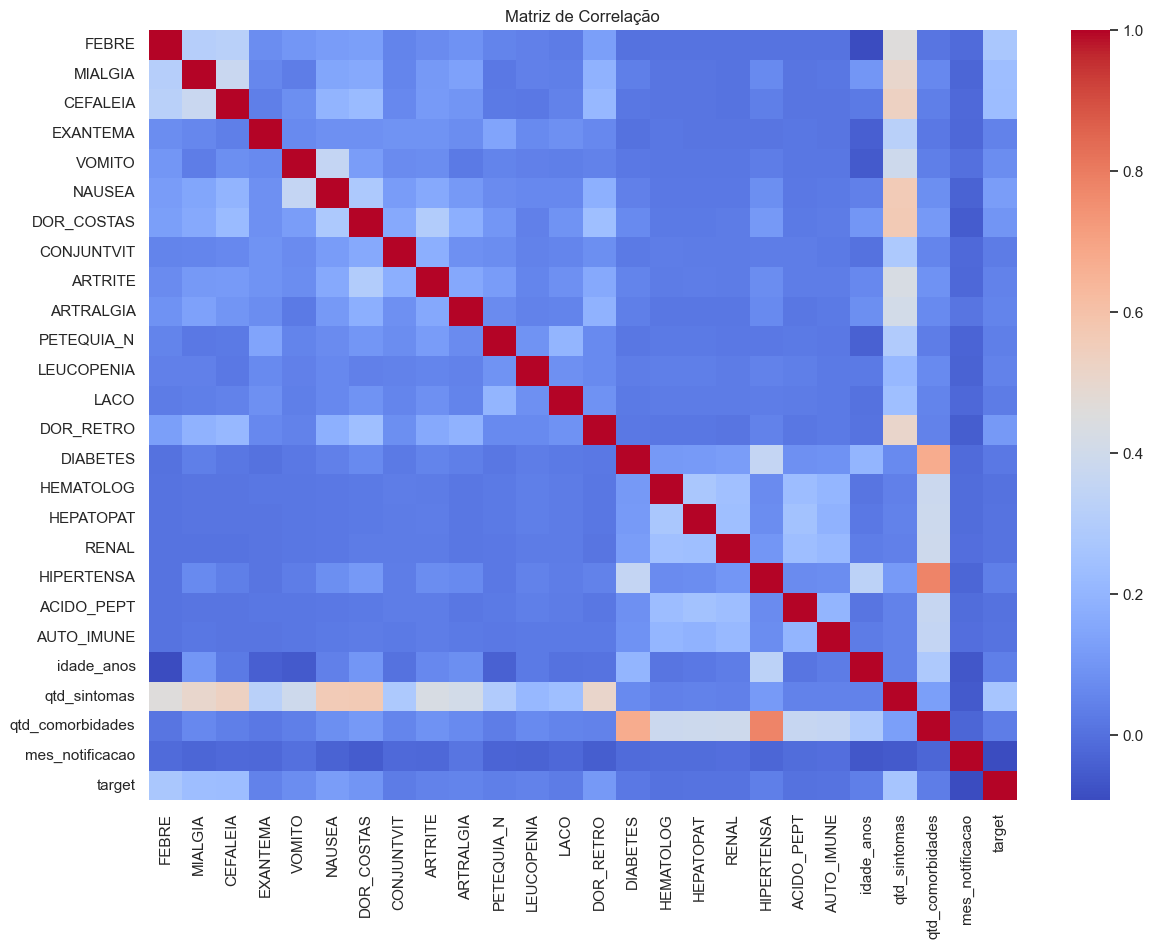

In [10]:
# Correlação
if X.shape[0] > 0:
    plt.figure(figsize=(14, 10))
    sns.heatmap(df_clean[cols_to_use + ['target']].corr(), cmap='coolwarm', annot=False)
    plt.title('Matriz de Correlação')
    plt.show()

## 4. Modelagem

In [11]:
if X.shape[0] > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
    print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (974462, 25), Teste: (417627, 25)


In [12]:
if X.shape[0] > 0:
    models = {
        'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))]),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=y_train.value_counts().get(0, 1)/y_train.value_counts().get(1, 1), random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"Treinando {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        results[name] = {
            'Recall': recall_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC-ROC': roc_auc_score(y_test, y_proba),
            'Model': model
        }
        print(f"  Recall: {results[name]['Recall']:.4f}, AUC: {results[name]['AUC-ROC']:.4f}")

Treinando Logistic Regression...
  Recall: 0.7562, AUC: 0.7473
Treinando Random Forest...
  Recall: 0.8780, AUC: 0.7124
Treinando XGBoost...
  Recall: 0.8357, AUC: 0.7711


In [13]:
# Comparativo
if results:
    df_res = pd.DataFrame(results).T.drop(columns=['Model'])
    display(df_res.style.background_gradient(cmap='Greens'))

,Recall,Precision,F1-Score,AUC-ROC
Logistic Regression,0.756177,0.941962,0.838907,0.747292
Random Forest,0.878024,0.934409,0.905340,0.712370
XGBoost,0.835694,0.943323,0.886252,0.771062


## 5. Interpretação

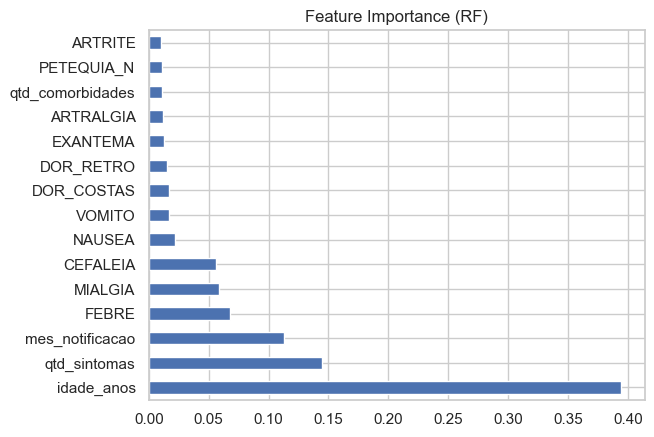

In [14]:
# Feature Importance (Random Forest)
if 'Random Forest' in results:
    rf = results['Random Forest']['Model']
    pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(15).plot(kind='barh', title='Feature Importance (RF)')
    plt.show()

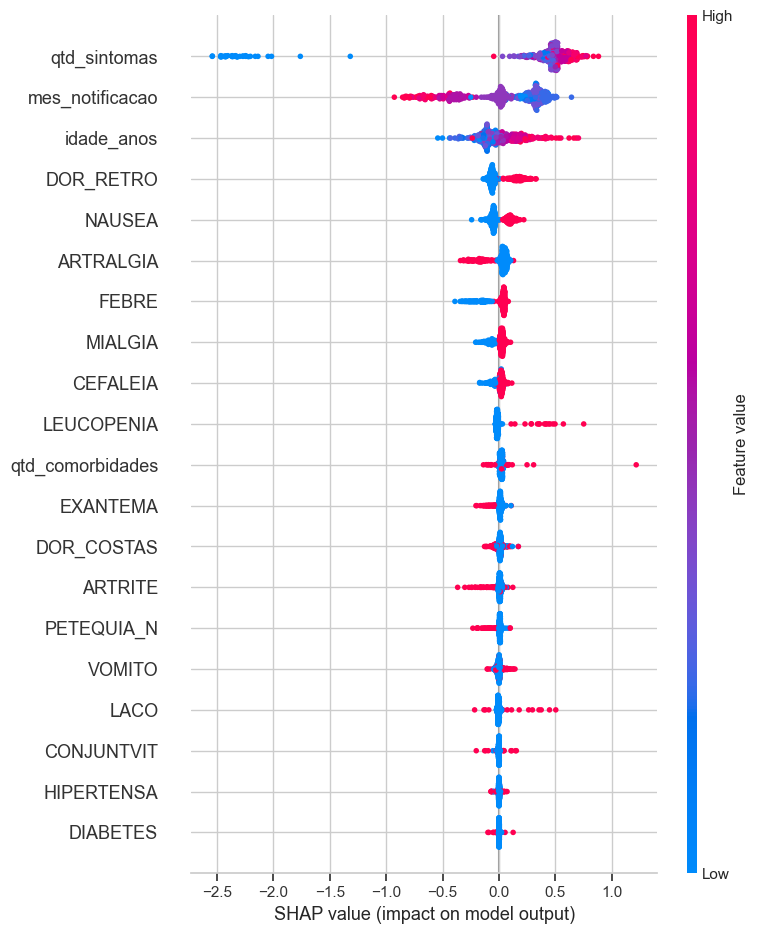

In [15]:
# SHAP
if 'XGBoost' in results:
    import shap
    shap.initjs()
    xgb = results['XGBoost']['Model']
    explainer = shap.TreeExplainer(xgb)
    
    # Amostra segura
    try:
        sample_size = min(500, X_test.shape[0])
        X_sample = X_test.iloc[:sample_size]
        shap_values = explainer.shap_values(X_sample, check_additivity=False)
        if isinstance(shap_values, list): shap_values = shap_values[1]
        shap.summary_plot(shap_values, X_sample)
    except Exception as e:
        print(f"Erro ao gerar SHAP: {e}")

## Conclusão

**Recall** foi priorizado pois falsos negativos são perigosos em contexto médico.
A análise SHAP mostra quais sintomas mais impactam o diagnóstico.